# Customer Support Agent

In [19]:
! pip install -q -U  langchain-google-genai langchain langgraph

^C


In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph.state import StateGraph,START,END,CompiledStateGraph
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv
import os
from typing_extensions import TypedDict
from IPython.display import Image,display

load_dotenv()

# Getting Gemini Api Key
google_api_key = os.getenv("GEMINI_API_KEY")

llm : ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash",api_key=google_api_key)

class State(TypedDict):
    query:str
    category:str
    sentiment:str
    response:str


In [ ]:
# Function for identifying Categorizes
def categorize(state:State)->dict[str,str]:
    "Categorize the customer query into these categories Technical,Billing and General"
    prompt = PromptTemplate(input_variables='query', template='Categorize the customer queries in the following categories.Respond with either Technical, Billing and General. Query : {query}')
    message = prompt.format(query=state['query'])
    category = llm.invoke(message).content
    return {"category" : category}

# Function for Sentiment_Analysis    
def sentiment_analysis(state:State)-> dict[str,str]:
    "Analyze the sentiment of the customer query as Positive , Negative and Neutral"
    prompt = PromptTemplate(input_variables="query",template='Analyze the sentiment of the following query in the following types.Respond with either Positive , Negative and Neutral. Query : {query}')
    message = prompt.format(query=state['query'])
    sentiment= llm.invoke(message).content
    return {"sentiment" : sentiment}

# Function for technical response 
def handle_technical(state:State)-> dict[str,str]:
    "Provide a technical support response to query"
    prompt = PromptTemplate(input_variables='query',template="Provide  technical support reponse to the following query : {query}")
    message =prompt.format(query=state['query'])
    response = llm.invoke(message).content
    return {"response" : response}

# Function for billing reponse
def handle_billing(state:State)-> dict[str,str]:
    "Provide a billing support response to query"
    prompt = PromptTemplate(input_variables='query',template="Provide  a billing support reponse to the following query : {query}")
    message =prompt.format(query=state['query'])
    response = llm.invoke(message).content
    return {"response" : response}

# Function for general response
def handle_general(state:State)-> dict[str,str]:
    "Provide a general support response to query"
    prompt = PromptTemplate(input_variables='query',template="Provide  general support reponse to the following query : {query}")
    message = prompt.format(query=state['query'])
    response = llm.invoke(message).content
    return {"response" : response}

# Function for Negative Sentiment response
def escalate(state:State)-> dict[str,str]:
    "Escalate the query to a human agent due to the negative sentiment of the query"
    return {"response" :"This query has been escalated to the humn agent due to the negative sentiment of the query"}

# Function for nodes route handling
def route_query(state:State)->str:
    if state['sentiment'] == 'Negative':
        return 'escalate'
    elif state['category'] == 'Billing':
        return 'handle_billing'
    elif state['category'] == 'Technical':
        return 'handle_technical'
    else :
        return 'handle_general'

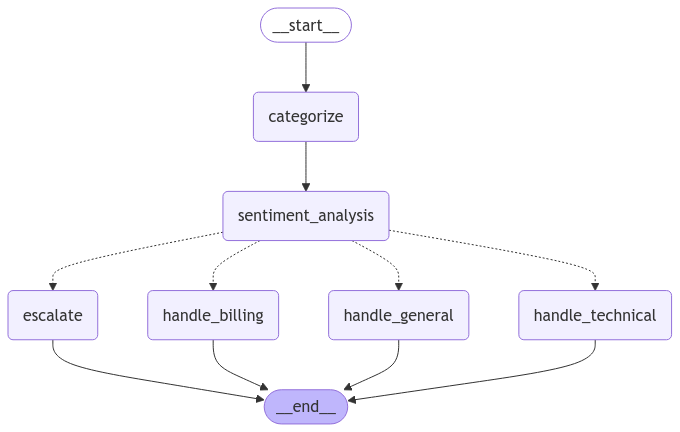

In [ ]:
workflow : StateGraph = StateGraph(State)

# Adding all the nodes of graph
workflow.add_node('categorize',categorize)
workflow.add_node('sentiment_analysis',sentiment_analysis)
workflow.add_node("handle_billing",handle_billing)
workflow.add_node('handle_technical',handle_technical)
workflow.add_node('handle_general',handle_general)
workflow.add_node('escalate',escalate)

# Joining All nodes by edges
workflow.add_edge('categorize','sentiment_analysis')
workflow.add_conditional_edges('sentiment_analysis',route_query,
                               {"handle_billing":"handle_billing",
                                "handle_general":"handle_general",
                                "handle_technical":"handle_technical",
                                "escalate" :"escalate"})

workflow.set_entry_point('categorize')

workflow.add_edge("handle_technical",END)
workflow.add_edge('handle_general',END)
workflow.add_edge('handle_billing',END)
workflow.add_edge('escalate',END)

graph : CompiledStateGraph = workflow.compile()

# Displaying Graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
from typing import Dict

def run_customer_support(query: str) -> Dict[str, str]:
    """Process a customer query through the LangGraph workflow.
    
    Args:
        query (str): The customer's query
        
    Returns:
        Dict[str, str]: A dictionary containing the query's category, sentiment, and response
    """
    results = graph.invoke({"query": query})
    print(type(results))
    return {
        "category": results["category"],
        "sentiment": results["sentiment"],
        "response": results["response"]
    }


### Testing the Agent

In [ ]:
# Test 1 
query = "My internet connection keeps dropping. Can you help?"
results = graph.invoke({"query": query })

print(f"Query: {query}")
print(f"Category: {results['category']}")
print(f"Sentiment: {results['sentiment']}")
print(f"Response: {results['response']}")
print("\n")


Query: My internet connection keeps dropping. Can you help?
Category: **Technical** 

Sentiment: Negative. 

Response: I understand your frustration!  It's really annoying when your internet connection keeps dropping.  To help me figure out what's going on, could you tell me a little more about the issue? 

For example:

* **How often does it drop?** (Once a day, every few hours, etc.)
* **How long does it stay down?** (A few seconds, minutes, longer?)
* **What device(s) are affected?** (Computer, phone, all devices?)
* **Is it a complete outage or is it just slow?**
* **Have you tried restarting your modem and router?**

Once I have a bit more information, I can give you some more specific troubleshooting steps. 





In [ ]:
# Test 2
query = "What is AI ?"
results = graph.invoke({"query": query })

print(f"Query: {query}")
print(f"Category: {results['category']}")
print(f"Sentiment: {results['sentiment']}")
print(f"Response: {results['response']}")
print("\n")

Query: What is AI ?
Category: **General** 

Sentiment: Neutral 

Response: AI, or Artificial Intelligence, is a field of computer science that focuses on creating intelligent machines that can perform tasks that typically require human intelligence. These tasks can include:

* **Learning:**  AI systems can learn from data and improve their performance over time.
* **Problem-solving:** AI can be used to solve complex problems, often finding solutions that humans might miss.
* **Decision-making:** AI systems can make decisions based on data and algorithms.
* **Natural language processing:** AI enables computers to understand and respond to human language.
* **Computer vision:** AI allows computers to "see" and interpret images and videos.

AI is a rapidly developing field with applications across many industries, including healthcare, finance, transportation, and entertainment. It's a powerful tool with the potential to change the way we live and work. 





In [ ]:
# Test 3
query = "Benefits of Yoga ?"
results = graph.invoke({"query": query })

print(f"Query: {query}")
print(f"Category: {results['category']}")
print(f"Sentiment: {results['sentiment']}")
print(f"Response: {results['response']}")
print("\n")

Query: Benefits of Yoga ?
Category: This query falls under the **General** category. 

It's not related to technical issues with a product or service, nor is it about billing or payments. It's a request for information about a broader topic, making it a general inquiry. 

Sentiment: Neutral. 

The query "Benefits of Yoga?" is simply asking for information. It doesn't express any opinion or feeling, positive or negative, about yoga. 

Response: Yoga offers a wide range of benefits that extend beyond physical health, impacting mental and emotional well-being. Here are some of the key advantages:

**Physical Benefits:**

* **Increased Flexibility and Strength:** Yoga postures work to improve flexibility, range of motion, and muscle strength.
* **Improved Balance and Coordination:** Balancing poses enhance balance, coordination, and stability.
* **Pain Relief:** Yoga can help alleviate pain associated with conditions like back pain, neck pain, and arthritis.
* **Enhanced Cardiovascular Hea